In [29]:
import gym
import numpy as np 
import matplotlib.pyplot as plt
import time
import random
from collections import deque
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import Sequential 
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import math
from tensorflow.keras.optimizers import Adam
from tqdm import trange

In [30]:
env = gym.make('LunarLander-v2',
    continuous= False,
    gravity = -10.0,
    enable_wind = True,
    wind_power = 5.0,
    turbulence_power= 0.5,)


In [31]:
env.action_space.n
env.observation_space.shape

(8,)

In [32]:

GAMMA = 0.99
LEARNING_RATE = 2.5e-4

MEMORY_SIZE = 1000000
BATCH_SIZE = 64

EPSILON_MAX = 1.0
EPSILON_MIN = 0.01
EXPLORATION_DECAY = 0.995

In [33]:
state_space=8
obs_space=5
action_space=4
intermediate_dim=16

In [34]:
class QModel:
    def __init__(self, input_dim, output_dim, lr):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.Qpolicy = self.create()
        self.Qtarget = self.create() 
        self.Qtarget.set_weights(self.Qpolicy.get_weights())
        
    def create(self):
        model = Sequential()
        model.add(Dense(512, input_dim = self.input_dim, activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(self.output_dim, activation = 'linear'))
        model.compile(optimizer = RMSprop(lr = self.lr, rho = 0.95, epsilon = 0.01), loss = "mse", metrics = ['accuracy'])
        return model

In [35]:
class DQNSolver:
    def __init__(self, state_space,action_space, decay_coe = 0.99975, 
                  memory_size = 10_000,  C = 5):
        
        #self.env = gym.make('CartPole-v0')

        self.states = state_space
        self.n_actions = action_space
        
        self.actions = [i for i in range(self.n_actions)]
        
        self.lr = LEARNING_RATE
        self.gamma = GAMMA
        self.epsilon = EPSILON_MAX
        self.decay_coe = decay_coe
        self.min_eps = EPSILON_MIN
        #self.episodes = episodes
        self.batch_size = BATCH_SIZE
        self.memory = deque(maxlen = memory_size) # replay memory 
        
        self.terminal_state = False # end of the episode
        self.target_counter = 0 
        
        # Plot data
        #self.timestep = self.episodes / 10

        
        
        
        self.model = QModel(self.states, self.n_actions, self.lr)
        # Smooth epsilon 
        # self.a = 0.35
        # self.b = 0.1
        # self.c = 0.01
        
    def state_shape(self,states):
        states = np.array(states)
        
        return states.reshape(-1,*states.shape)
    def update_target_model(self):
        """
        Updates the current target_q_net with the q_net which brings all the
        training in the q_net to the target_q_net.
        :return: None
        """
        self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
    def decrement_epsilon(self):
        '''
        if self.epsilon > self.min_eps:
            self.epsilon *= self.decay_coe
        else:
            self.epsilon = self.min_eps
        '''
        # s_time = (time - self.a*self.episodes) / (self.b*self.episodes) 
        # cosh = np.cosh(math.exp(-s_time))
        # self.epsilon = 1 - (1/cosh + (time*self.c/self.episodes))
        if self.epsilon>self.min_eps:
            self.epsilon*=0.98
        else:
            self.epsilon=self.min_eps
    def forget(self):
        self.memory.clear()

    def remember(self, s, a, r, s_, done):
        self.memory.append([self.state_shape(s), a, r, self.state_shape(s_), done])
        
    def act(self, states):
        if np.random.random() > (1 - self.epsilon):
            action = np.random.choice(self.actions)
        else:
            states = self.state_shape(states)
            action = np.argmax(self.model.Qpolicy.predict(states))
            
        return action
            
    def minibatch(self):
        return random.sample(self.memory, self.batch_size)
    

        #plt.savefig(r'RL/loss - e{}v2.png'.format(episode), dpi = 500)
        
    def train(self):
        # X - states passed to the NN, y - target
        
        X, y = [], []
        
        if len(self.memory) >= self.batch_size: 
            SARS = self.minibatch()
        
            s = self.state_shape([row[0] for row in SARS])
            qvalue = self.model.Qpolicy.predict(s)[0]
            #print(qvalue)

            s_ = self.state_shape([row[3] for row in SARS])
            future_qvalue = self.model.Qtarget.predict(s_)[0]

            for index, (state, action, reward, state_, done) in enumerate(SARS):
                if done == True:
                    Qtarget = reward
                else:
                    Qtarget = reward + self.gamma * np.max(future_qvalue[index])
            
                qcurr = qvalue[index][0]
                #print(qcurr)
                qcurr[int(action)] = Qtarget                
                X.append(state)
                y.append(qcurr)
                
            X, y = np.array(X).reshape(1,self.batch_size,1,self.states), np.array(y).reshape(1,self.batch_size, 1, self.n_actions)
                                        
            loss = self.model.Qpolicy.fit(X, y, batch_size = self.batch_size, shuffle = False, verbose = 0)
            #self.history.append(loss.history['loss'][0])
            
                
            # if self.terminal_state:
            #     self.target_counter+=1

            # # C -> target network update frequency
            # if self.target_counter > self.C: 
            #     self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
            #     self.target_counter = 0 

                
  

In [36]:
dqn_solver=DQNSolver(state_space=state_space,action_space=action_space)


c:\Users\prati\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [37]:
scores=[]
no_train=[]


In [54]:
s=env.reset()
s=s[0]
print(s)

[ 5.7125092e-04  1.4035593e+00  5.7806902e-02 -3.2714674e-01
 -6.2538241e-04 -1.2513550e-02  0.0000000e+00  0.0000000e+00]


In [55]:
s=[s[0],s[1],s[4],s[6],s[7]]
print(s)

[0.0005712509, 1.4035593, -0.0006253824, 0.0, 0.0]


In [39]:
#dqn_solver.memory[0]

In [40]:
#qn_solver.state_shape(dqn_solver.memory[0][0])

In [41]:
def training(dqn_solver,n_episodes=500,maxt=1000):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
     # last 100 scores
    trains=0
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        state=state[0]
        score = 0

        done=False

        for t in tqdm(range(maxt),leave=False,desc=str(i_episode)):
            action = dqn_solver.act(state)
            next_state, reward, done, _,_ = env.step(action)
            
            dqn_solver.remember(state,action,reward,next_state,done)

            dqn_solver.train()
            trains+=1
            state = next_state
            score += reward
            if done:
                break
            
        dqn_solver.decrement_epsilon()
        scores.append(score)
        no_train.append(trains)             # save most recent score
        if(i_episode%5==0):
            dqn_solver.update_target_model()
        if(i_episode%20==0):
            print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, score, end=""))




In [42]:
training(dqn_solver)

1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 20	Score: -43.58


Episode 40	Score: -64.26


Episode 60	Score: -71.43


Episode 80	Score: -83.60


Episode 100	Score: -141.53


Episode 120	Score: -93.60


Episode 140	Score: -54.42


Episode 160	Score: -16.41


Episode 180	Score: -182.84


Episode 200	Score: 39.63


Episode 220	Score: -49.28


Episode 240	Score: -48.25


Episode 260	Score: -17.44


Episode 280	Score: 11.43


Episode 300	Score: -37.98


Episode 320	Score: -76.61


Episode 340	Score: -67.18


Episode 360	Score: -23.08


Episode 380	Score: -440.39


Episode 400	Score: -205.83


Episode 420	Score: 49.17


Episode 440	Score: -154.25


Episode 460	Score: 222.60


Episode 480	Score: -113.19


Episode 500	Score: -59.69


In [43]:
scores

[-117.16491758107878,
 -94.00792156961505,
 -349.8875928427799,
 -105.79953325319104,
 -37.8150446188593,
 -83.22943970863122,
 -183.5430474958121,
 -487.99632842129313,
 -276.13218108617906,
 -149.82144139757162,
 -103.85356071826979,
 -118.07914674875434,
 -53.4779237955767,
 -174.7710340314282,
 -163.9956147847547,
 -94.31152816323022,
 -164.96325779348223,
 -131.74632548243855,
 -296.99635094122254,
 -43.58019547263649,
 -81.39730139103966,
 -355.6603849210881,
 -115.28216724629918,
 -91.88202507403753,
 -99.74617548277374,
 -53.95493239542719,
 -235.2876977567688,
 -67.42851912042364,
 -120.58964128287963,
 -45.46284412699568,
 -148.5418681364656,
 -207.3200687985068,
 -235.4985886005959,
 -103.1694830785535,
 -100.58188522477364,
 -80.08740782921659,
 -27.4440087762988,
 -117.52550264441143,
 -129.63365594329397,
 -64.26003463361411,
 -215.82688640939182,
 -75.54748857387484,
 -91.87525862228586,
 -245.05465690491744,
 -132.72028901842629,
 -122.50390417770349,
 -91.3060038207044

In [44]:
import pandas as pd
df=pd.DataFrame(scores)
df.columns=['scores']
df.to_csv('rewards_only_dqn_normal_lunar_2.csv')

In [45]:
df

,scores
0,-117.164918
1,-94.007922
2,-349.887593
3,-105.799533
4,-37.815045
...,...
495,237.224229
496,208.121005
497,257.532410
498,132.303439


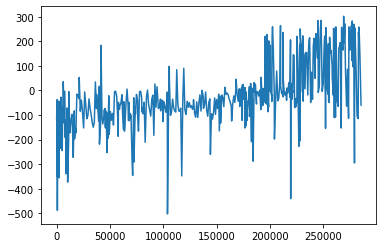

In [46]:
import matplotlib.pyplot as plt
plt.plot(no_train,scores)

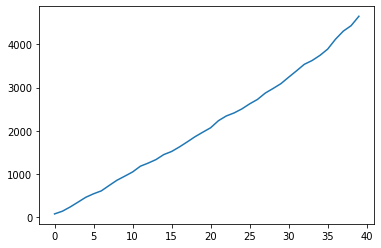

In [47]:
plt.plot(no_train[0:40])

In [48]:
ls=[]
for x in scores:
    if x>0:
        ls.append(x)
    else:
        ls.append(0.0)

In [49]:
df['positive']=ls
df['moving_avg']=df.scores.rolling(100,min_periods=1).mean()

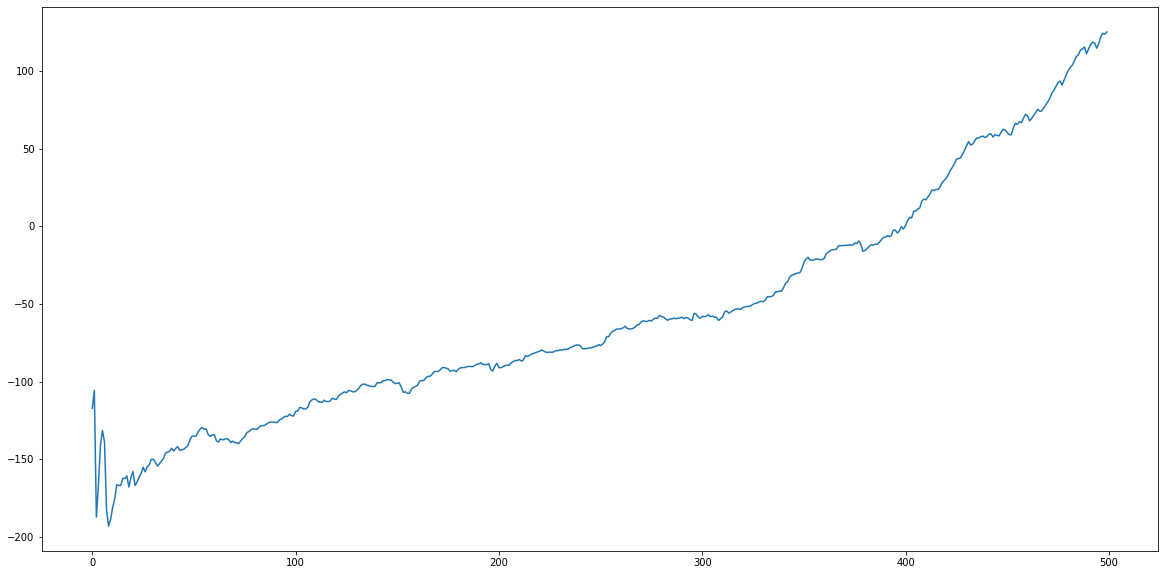

In [50]:
plt.rcParams['figure.figsize']=[20,10]

plt.plot(df['moving_avg'])

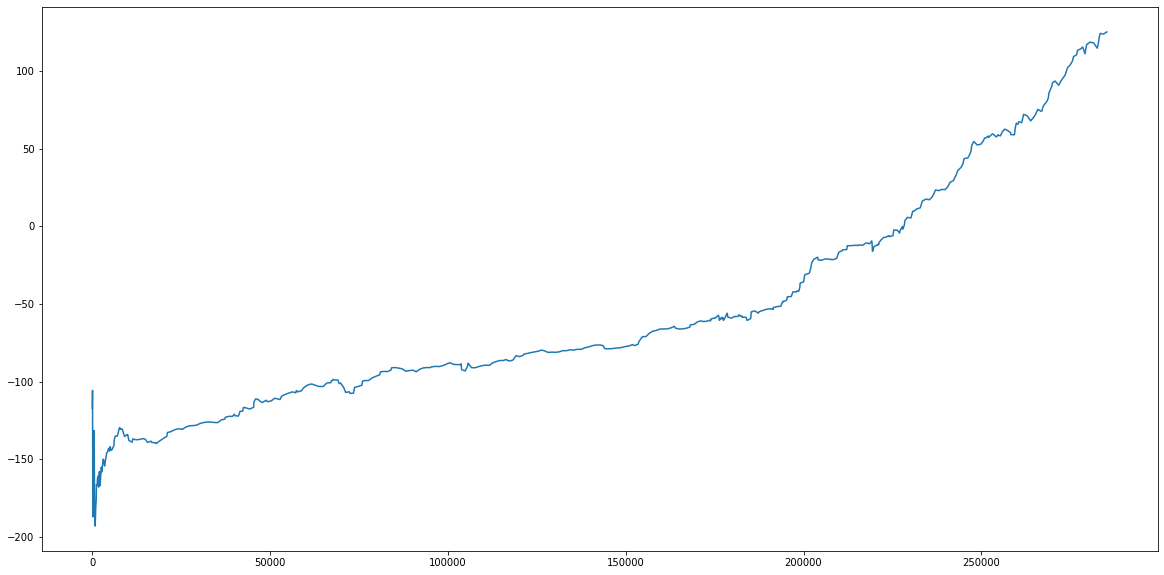

In [52]:
plt.plot(no_train,df['moving_avg'])